In [23]:
import pandas as pd
from utils import average_countries_to_continents
import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from Environment.read_co2 import read_co2_continent
from predictions.predictions import autoregressive_integrated_moving_average
# from visualizations.world_map import create_world_bubble_map
import warnings
warnings.filterwarnings('ignore')


data_list_health = ['./data/health/cleaned_data/cleaned_Life expectancy at birth.csv',
                    './data/health/cleaned_data/cleaned_Mortality rate, infant (per 1,000 live births).csv']
data_list_economy = ['./data/economy/cleaned_data/cleaned_GDP.csv',
                 './data/economy/cleaned_data/cleaned_Unemployment, total (% of labour force).csv']

min_year = 1991
max_year = 2016
health_data = []
for data in data_list_health:
    #cluster to continents
    health_df = pd.read_csv(data, index_col=0)
    avg_health_df_new = average_countries_to_continents(health_df)
    columns_to_drop = []
    for column in avg_health_df_new.columns:
        if int(column) < min_year or int(column) > max_year:
            columns_to_drop.append(column)
    avg_health_df = avg_health_df_new.drop(columns=columns_to_drop)
    health_data.append(avg_health_df)

#pct change operates on cols, hence transposing
health_data[0] = health_data[0].T
africa = health_data[1].iloc[0].pct_change()
health_data[0] = health_data[0].pct_change()
health_data[0].iloc[0] = africa
health_data[0] = health_data[0].T

health_data[1] = health_data[1].T
africa = health_data[1].iloc[0].pct_change()
health_data[1] = health_data[1].pct_change()
health_data[1].iloc[0] = africa
health_data[1] = health_data[1].T



#health_data[0] =  (health_data[0] - health_data[0].mean()) / health_data[0].std()
health_data[1] = - (health_data[1]) # inverse when the higher the better
#health_data[1] = 1-( health_data[1] -  health_data[1].mean()) /  health_data[1].std()# inversely normalize when the higher the better

avg_health_df = pd.concat([health_data[0], health_data[1]], axis=1).groupby(axis=1, level=0).mean()


econ_data = []
for data in data_list_economy:
    economy_df = pd.read_csv(data, index_col=0)
    avg_economy_df_new = average_countries_to_continents(economy_df)
    columns_to_drop = []
    for column in avg_economy_df_new.columns:
        if int(column) < min_year or int(column) > max_year:
            columns_to_drop.append(column)

    #avg_economy_df_new = (avg_economy_df_new - avg_economy_df_new.mean()) / avg_economy_df_new.std()
    avg_economy_df = avg_economy_df_new.drop(columns=columns_to_drop)
    econ_data.append(avg_economy_df)


econ_data[0] = econ_data[0].T
africa = econ_data[1].iloc[0].pct_change()
econ_data[0] = econ_data[0].pct_change()
econ_data[0].iloc[0] = africa
econ_data[0] = econ_data[0].T

econ_data[1] = econ_data[1].T
africa = econ_data[1].iloc[0].pct_change()
econ_data[1] = econ_data[1].pct_change()
econ_data[1].iloc[0] = africa
econ_data[1] = econ_data[1].T
#econ_data[0] = (econ_data[0] - econ_data[0].mean()) / econ_data[0].std()
econ_data[1] = - econ_data[1] # inverse when the higher the better
#econ_data[1] = 1-(econ_data[1] - econ_data[1].mean()) / econ_data[1].std()
avg_economy_df = pd.concat([econ_data[0], econ_data[1]], axis=1).groupby(axis=1, level=0).mean()

environment_data = []
for column in ['co2', 'methane']:
    environment_co2 = read_co2_continent(year_start=1990, year_end=2016, usecols=['country', 'year','co2','methane'])
    data_grouped_by_entity = environment_co2.groupby('area')
    co2_groups = [data_grouped_by_entity.get_group(x) for x in data_grouped_by_entity.groups]
    co2_group = co2_groups[0]
    cleaned_co2_df = co2_group[['year', column]]
    cleaned_co2_df = cleaned_co2_df.set_index('year')
    cleaned_co2_df.columns = [co2_group['area'].iloc[0]]

    for i in range(1,len(co2_groups)):
        co2_group = co2_groups[i]
        co2_column = co2_group[['year', 'co2']]
        co2_column = co2_column.set_index('year')
        co2_column.columns = [co2_group['area'].iloc[0]]
        cleaned_co2_df = cleaned_co2_df.join(co2_column)
    cleaned_co2_df = cleaned_co2_df.T[:-1]
    cleaned_co2_df.columns = cleaned_co2_df.columns.map(str)
    cleaned_co2_df =  - cleaned_co2_df
    #cleaned_co2_df = 1-(cleaned_co2_df - cleaned_co2_df.mean()) / cleaned_co2_df.std()
    environment_data.append(cleaned_co2_df)

environment_data[0] = environment_data[0].T
africa = environment_data[0].iloc[0].pct_change()
environment_data[0] = environment_data[0].pct_change()
environment_data[0].iloc[0] = africa
environment_data[0] = environment_data[0].T

environment_data[1] = environment_data[1].T
africa = environment_data[1].iloc[0].pct_change()
environment_data[1] = environment_data[1].pct_change()
environment_data[1].iloc[0] = africa
environment_data[1] = environment_data[1].T

avg_env_df = pd.concat([environment_data[0], environment_data[1]], axis=1).groupby(axis=1, level=0).mean()
common_cols =  avg_health_df.columns & avg_economy_df.columns & avg_env_df.columns
avg_env_df = avg_env_df[common_cols]
avg_health_df = avg_health_df[common_cols]
avg_economy_df = avg_economy_df[common_cols]

avg_env_df = avg_env_df.drop(columns='1991')
avg_health_df = avg_health_df.drop(columns='1991')
avg_economy_df = avg_economy_df.drop(columns='1991')

a, b = autoregressive_integrated_moving_average(avg_env_df.T, seasonal_order = (1, 1, 0, 1))
a = a.set_index('Year')
b = b.set_index('Year')
avg_env_df = pd.concat([a.T,b[8:].T], axis=1)
a, b = autoregressive_integrated_moving_average(avg_health_df.T, seasonal_order = (1, 1, 0, 1))
a = a.set_index('Year')
b = b.set_index('Year')
avg_health_df = pd.concat([a.T, b[8:].T], axis=1)
a, b = autoregressive_integrated_moving_average(avg_economy_df.T, seasonal_order = (1, 1, 0, 1))
a = a.set_index('Year')
b = b.set_index('Year')
avg_economy_df = pd.concat([a.T, b[8:].T], axis=1)


# print(avg_env_df)
# print(avg_health_df)
# print(avg_economy_df)
# create_world_bubble_map(avg_health_df, avg_env_df, avg_economy_df, 'world_overall.png')

In [24]:
avg_health_df

Year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
Continent,,,,,,,,,,,,,,,,,,,,,
Africa,0.005557,0.005780,0.006199,0.006658,0.010489,0.010751,0.011155,0.011527,0.012156,0.017956,...,0.010731,0.009997,0.009263,0.008528,0.007794,0.007060,0.006326,0.005591,0.004857,0.004123
Asia,0.015042,0.015253,0.015721,0.016123,0.018952,0.019590,0.020502,0.021163,0.022022,0.023466,...,0.009958,0.009156,0.008354,0.007552,0.006750,0.005948,0.005147,0.004345,0.003543,0.002741
Europe,0.015908,0.016442,0.017205,0.017887,0.021361,0.022398,0.023343,0.024502,0.025560,0.024371,...,0.009913,0.009056,0.008199,0.007341,0.006484,0.005627,0.004769,0.003912,0.003055,0.002197
North America,0.018091,0.018493,0.019030,0.019415,0.016179,0.016648,0.016985,0.017734,0.017945,0.013430,...,0.005591,0.005196,0.004801,0.004406,0.004011,0.003616,0.003221,0.002826,0.002431,0.002036
Oceania,0.015049,0.015237,0.015513,0.016081,0.011511,0.011959,0.012075,0.012200,0.012601,0.008190,...,0.019647,0.020278,0.020910,0.021541,0.022173,0.022804,0.023436,0.024067,0.024699,0.025330
South America,0.020639,0.021127,0.022107,0.022791,0.021299,0.022072,0.022912,0.023755,0.024683,0.019448,...,0.011075,0.010752,0.010428,0.010105,0.009781,0.009458,0.009134,0.008811,0.008487,0.008164


In [25]:
avg_env_df

Year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
Africa,-0.025499,0.060424,0.015224,0.072210,0.013798,0.038322,0.029717,-0.009242,0.073443,-0.006935,...,-0.008944,-0.010112,-0.011284,-0.012455,-0.013626,-0.014797,-0.015968,-0.017139,-0.018310,-0.019481
Asia,0.037827,0.046896,0.043915,0.040479,0.043139,0.012440,-0.030736,0.029520,0.050054,0.016702,...,-0.004536,-0.006033,-0.007531,-0.009028,-0.010526,-0.012023,-0.013521,-0.015018,-0.016516,-0.018013
Europe,-0.115388,-0.040498,-0.051984,-0.002403,0.007194,-0.030841,-0.004869,-0.014079,0.000569,0.021551,...,0.023062,0.025290,0.027519,0.029747,0.031975,0.034204,0.036432,0.038660,0.040889,0.043117
North America,0.019592,0.018853,0.020536,0.010025,0.035276,0.017498,0.010584,0.015654,0.030447,-0.011848,...,-0.038348,-0.040085,-0.041821,-0.043557,-0.045294,-0.047030,-0.048766,-0.050503,-0.052239,-0.053975
Oceania,0.023031,0.013196,0.015808,0.035073,0.025231,0.030055,0.035482,0.029320,0.019541,0.026084,...,0.025452,0.025745,0.026037,0.026329,0.026621,0.026913,0.027206,0.027498,0.027790,0.028082
South America,0.015910,0.057881,0.028879,0.049725,0.046835,0.057119,0.071145,0.019221,-0.024494,0.014182,...,-0.056590,-0.059460,-0.062324,-0.065190,-0.068055,-0.070921,-0.073786,-0.076652,-0.079517,-0.082383


In [26]:
avg_economy_df

Year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
Continent,,,,,,,,,,,,,,,,,,,,,
Africa,0.006349,-0.020630,-0.022708,0.026326,0.028689,0.015787,-0.008696,0.008957,0.014749,-0.007492,...,-0.188657,-0.201562,-0.214468,-0.227373,-0.240279,-0.253184,-0.266090,-0.278995,-0.291901,-0.304806
Asia,0.004476,0.023897,0.011402,0.032143,-0.041730,-0.037721,-0.066782,0.037496,0.029532,-0.042134,...,-0.008550,-0.009358,-0.010166,-0.010974,-0.011783,-0.012591,-0.013399,-0.014207,-0.015015,-0.015823
Europe,-0.009608,-0.091589,-0.015725,0.037590,0.012102,-0.036036,0.018543,0.001521,-0.035159,0.014121,...,0.058825,0.061647,0.064469,0.067290,0.070112,0.072934,0.075755,0.078577,0.081399,0.084220
North America,0.015113,0.030552,0.012968,-0.057455,0.049379,0.067786,0.020545,0.063587,0.080349,0.012192,...,-0.026168,-0.027513,-0.028859,-0.030205,-0.031550,-0.032896,-0.034242,-0.035587,-0.036933,-0.038279
Oceania,0.001254,0.001507,0.079504,0.051258,0.051253,-0.001651,-0.062345,0.040428,-0.026688,-0.003906,...,-0.009675,-0.011714,-0.013752,-0.015791,-0.017830,-0.019868,-0.021907,-0.023946,-0.025984,-0.028023
South America,0.021721,0.034816,0.133309,0.101905,0.014235,0.005393,-0.033269,-0.125057,0.004514,-0.023094,...,-0.162351,-0.170552,-0.178753,-0.186954,-0.195155,-0.203356,-0.211557,-0.219758,-0.227959,-0.236160


In [27]:
import plotly.express as px
import matplotlib.pyplot as plt

In [28]:
continent = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America', 'World']
year = list(map(str, range(min_year, max_year+1)))

In [50]:
# avg_economy_df.mean(axis=0)
avg_economy_df = avg_economy_df.append(avg_economy_df.mean(axis=0), ignore_index=True)
avg_env_df = avg_env_df.append(avg_env_df.mean(axis=0), ignore_index=True)
avg_health_df = avg_health_df.append(avg_health_df.mean(axis=0), ignore_index=True)



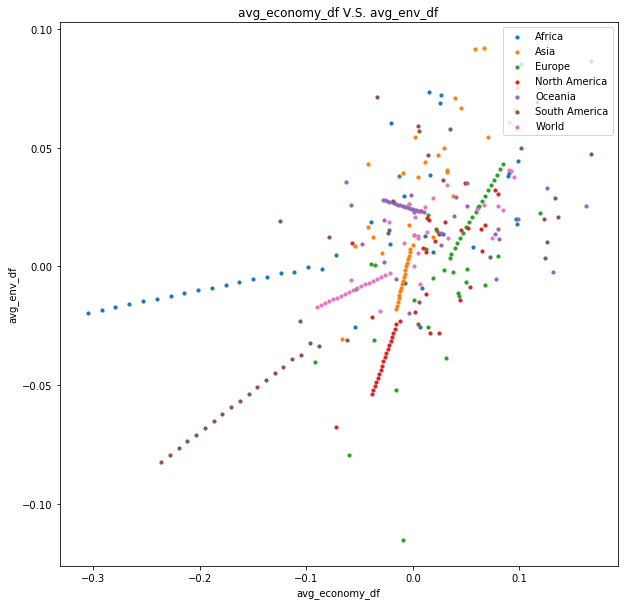

In [53]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

for i, c in enumerate(continent):
    plt.scatter(avg_economy_df.iloc[i], avg_env_df.iloc[i], s=10, label=c)


plt.legend(loc='upper right')
plt.gca().update(dict(title='avg_economy_df V.S. avg_env_df', xlabel='avg_economy_df', ylabel='avg_env_df'))
plt.show()
fig.savefig('avg_economy_df V.S. avg_env_df.png', transparent=True)

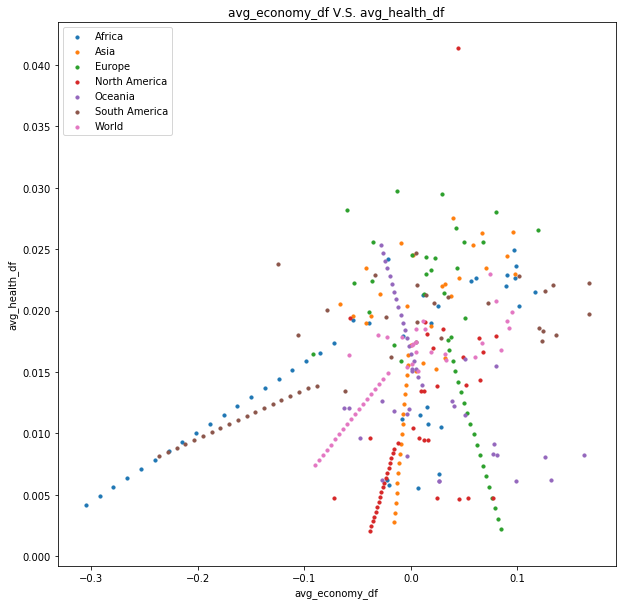

In [54]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

for i, c in enumerate(continent):
    plt.scatter(avg_economy_df.iloc[i], avg_health_df.iloc[i], s=10, label=c)

plt.legend(loc='upper left')
plt.gca().update(dict(title='avg_economy_df V.S. avg_health_df', xlabel='avg_economy_df', ylabel='avg_health_df'))
plt.show()
fig.savefig('avg_economy_df V.S. avg_health_df.png', transparent=True)

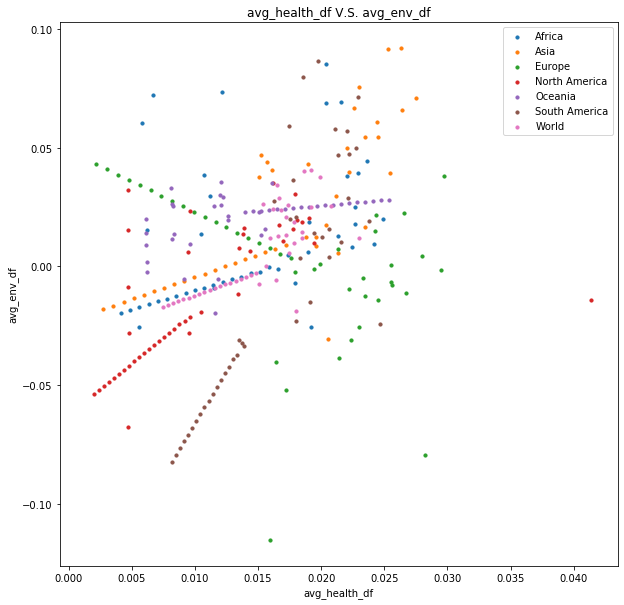

In [55]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

for i, c in enumerate(continent):
    plt.scatter(avg_health_df.iloc[i], avg_env_df.iloc[i], s=10, label=c)

plt.legend(loc='upper right')
plt.gca().update(dict(title='avg_health_df V.S. avg_env_df', xlabel='avg_health_df', ylabel='avg_env_df'))
plt.show()
fig.savefig('avg_health_df V.S. avg_env_df.png', transparent=True)